<a href="https://colab.research.google.com/github/diyuenji/Crop_IDcard-image/blob/main/Crop_ID_card_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%%time
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

CPU times: user 1.81 ms, sys: 953 µs, total: 2.76 ms
Wall time: 2.63 ms


In [ ]:
!pip install ultralytics

# Import library

In [ ]:
from ultralytics import YOLO
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# Access to gg drive

In [12]:
%%time
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AI/YOLO/Hình ảnh

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AI/YOLO/Hình ảnh
CPU times: user 27.8 ms, sys: 2.65 ms, total: 30.4 ms
Wall time: 3.08 s


# Set up SAM environment

In [13]:
%%time
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    # !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    # !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3ghm1dpb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3ghm1dpb
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
CPU times: user 982 ms, sys: 155 ms, total: 1.14 s
Wall time: 5.74 s


In [14]:
from segment_anything import sam_model_registry, SamPredictor
from timeit import default_timer as timer
start_time = timer()

sam_checkpoint = "/content/drive/MyDrive/AI/SAM model checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
end_time = timer()
print(f"Total load 1st time: {end_time-start_time:.3f} seconds")

Total load 1st time: 25.122 seconds


# Function definition

In [16]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [17]:
# def convert(bb_n,img_w=640,img_h=480):
#   #bb_n format x,y,w,h
#   new_bb=np.array([0.0,0.0,0.0,0.0])
#   bbox_w=bb_n[2]*img_w
#   bbox_h=bb_n[3]*img_h
#   new_bb[0]=bb_n[0]*img_w-bbox_w/2 #tleft_x
#   new_bb[1]=bb_n[1]*img_h-bbox_h/2 #bright_x
#   new_bb[2]=bb_n[0]*img_w+bbox_w/2 #tleft_y
#   new_bb[3]=bb_n[1]*img_h+bbox_h/2 #bright_y

#   return new_bb

In [18]:
import numpy as np
def define_corner(mask):

  width=len(mask[0])
  height=len(mask)

  # print(width)
  # print(height)
  C_x=-1
  C_y=-1

  A_x=width
  A_y= -1

  D_y=-1
  D_x =-1

  B_y=height
  B_x=-1
  for h in range (0,height):
    for w in range (0,width):
      if mask[h][w]==True:
        if w<A_x:
          A_x=w
          A_y=h
        if w>C_x:
          C_x=w
          C_y=h
        if h<B_y:
          B_x=w
          B_y=h
        if h>D_y:
          D_x=w
          D_y=h
  output_list=np.array([[A_x , A_y] , [B_x , B_y], [C_x, C_y ], [D_x, D_y]])
  return output_list


In [19]:
def angle_2vect(vecto1,vecto2):
  dot_product = np.dot(vecto1, vecto2)  # Tich vo huong
  norm_vecto1 = np.linalg.norm(vecto1)  # Chieu dai dai so v1
  norm_vecto2 = np.linalg.norm(vecto2)  # Chieu dai dai so v2
  cos_angle = dot_product / (norm_vecto1 * norm_vecto2)
  angle_rad = np.arccos(cos_angle)
  angle_deg = np.degrees(angle_rad)
  return angle_deg

# Define the corner of image
## Read image

In [ ]:
image = cv2.imread('/content/drive/MyDrive/AI/YOLO/Hình ảnh/Train/images/QUE_NCOV_04_03_18641_1.jpg')

# image = cv2.imread('/content/drive/MyDrive/AI/YOLO/Hình ảnh/Train/images/QUE_NCOV_04_03_19254_1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape
w=image.shape[1]
h=image.shape[0]
image

## Get bounding box of ID card use YOLO pretrained weight

In [ ]:
model = YOLO("/content/drive/MyDrive/AI/YOLO/ID detect_yolo weights/best.pt")  # load a custom model

# Predict with the model
results = model(image)

for result in results:
  boxes = result.boxes
  result.show()

tleft_x, tleft_y = int(boxes.xyxy[0][0]), int(boxes.xyxy[0][2])
bright_x, bright_y = int(boxes.xyxy[0][1]), int(boxes.xyxy[0][3])

In [63]:
# filename="/content/drive/MyDrive/AI/YOLO/Hình ảnh/Train/labels/QUE_NCOV_04_03_18641_1.txt"
# input_box = np.array([0.0 , 0.0 , 0.0 , 0.0])

# with open(filename,'r') as file:
#   count=0
#   for line in file:
#       for word in line.split():
#         if count>0:
#           input_box[count-1]=word
#         count+=1

# input_box1 = convert(input_box)
input_box =np.array([ tleft_x, bright_x, tleft_y, bright_y])
input_box

(array([165,   0, 566, 478]),
 array([     181.85,     0.79992,       544.8,      466.48]))

## Define central point depend on boundng box

In [64]:
input_point=np.array([[0.0,0.0]])
input_point[0][0]=(input_box[2]-input_box[0])/2+input_box[0] # (tleft_y-tleft_x)/2+tleft_x
input_point[0][1]=(input_box[3]-input_box[1])/2+input_box[1] #
input_point

array([[      365.5,         239]])

In [65]:
input_label = np.array([1])

## Use Sam to create mask of ID card

In [66]:
%%time
predictor.set_image(image)

CPU times: user 1.77 s, sys: 5.22 ms, total: 1.77 s
Wall time: 1.77 s


In [67]:
%%time
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    # point_coords=None,
    # point_labels=None,
    box=input_box,  # Bounding box of ID card
    multimask_output=False,
)

CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 18.4 ms


In [68]:
%%time
uniqueRows =np.unique(masks[0].reshape(-1, 1), axis=0, return_counts=True)
uniqueRows

CPU times: user 313 ms, sys: 2.25 ms, total: 315 ms
Wall time: 327 ms


(array([[False],
        [ True]]),
 array([158223, 148977]))

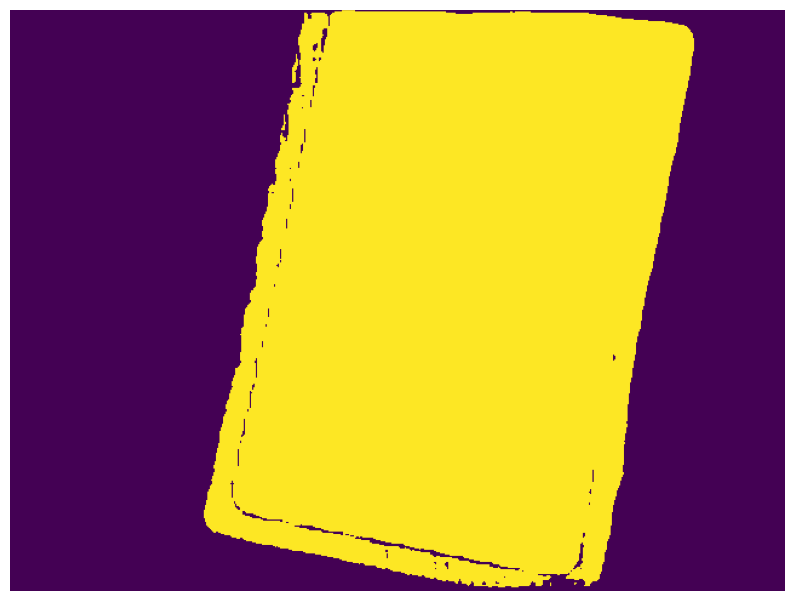

In [69]:
plt.figure(figsize=(10, 10))
plt.imshow(masks[0])

plt.axis('off')
plt.show()

## Deffine 4 corner through ID card mask

In [70]:
# np.array([[x_max , y_x_max] , [x_min , y_x_min], [x_y_max,y_max ], [x_y_min,y_min]])
# corner=np.array([[619,  34],
#        [223, 459],
#        [515, 478],
      #  [275,   1]])
corner=define_corner(masks[0])
# corner
# corner= np.array([[ 59, 254],
#        [128,  13],
#        [541,  99],
#        [472, 359]])
# corner.shape

In [71]:
input_pointA=np.expand_dims(corner[0], axis=0)
input_pointB=np.expand_dims(corner[1], axis=0)
input_pointC=np.expand_dims(corner[2], axis=0)
input_pointD=np.expand_dims(corner[3], axis=0)


In [72]:
input_point

array([[      365.5,         239]])

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
# show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
show_points(input_pointA, input_label, plt.gca())
show_points(input_pointB, input_label, plt.gca())
show_points(input_pointC, input_label, plt.gca())
show_points(input_pointD, input_label, plt.gca())
plt.axis('off')
plt.show()

# Adjust identification card






## Define if ID card rotate clockwise or counterclockwise

In [74]:
print(input_pointA)
print(input_pointC)

[[160 413]]
[[564  24]]


In [75]:
vecto_AC = input_pointC- input_pointA
vecto_BD = input_pointD- input_pointB
print(vecto_AC)
print(vecto_BD)

[[ 404 -389]]
[[121 475]]


In [76]:
angle = angle_2vect(vecto_AC[0,:],vecto_BD[0,:])  # Remove 1st dimension
print(angle)

119.62495660418755


## Use perspective transformation

### Define projective matrix

In [77]:
src_points = np.float32([input_pointA[0,:], input_pointB[0,:], input_pointC[0,:], input_pointD[0,:]])
dst_points = np.float32([[0,h-1], [0,0], [w-1,0], [w-1,h-1]]) if angle <90 else  np.float32([[0,0], [w-1,0], [w-1,h-1],[0,h-1]])
M = cv2.getPerspectiveTransform(src_points, dst_points)

### Define transformed image

In [ ]:
projective_image = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))
plt.imshow(projective_image)